In [1]:
from ckanapi import RemoteCKAN
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from pandas.io.json import json_normalize

ua = 'avoindata_ckanapi_example/1.0 ({0})'
ckan = RemoteCKAN('https://beta.avoindata.fi/data/fi/', user_agent=ua)
packages = ckan.action.package_search(q='Kansaneläkelaitos', fq = 'title:etuuksien')
resources = packages['results'][0]['resources'] 
url_csv = resources[0]['url']
url_json = resources[1]['url']
dat = pd.read_csv(url_csv, sep = ';', decimal = ',')

/home/e275ceo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
response = urlopen(url_json)
meta = json.loads(response.read())

## Datan ja metadatan kuvailu

**Datan kuvaustieto**

In [3]:
print(meta['description'])

Aineisto sisältää tiedot Kelan maksamien etuuksien saajista, maksetuista etuuksista ja keskimääräisistä etuuksista (euroa/saaja). Raportti kattaa valtaosan Kelan maksamista etuuksista. Maksetuista etuuksista kuitenkin puuttuvat työnantajien järjestämästä työterveyshuollosta, yrittäjien työterveyshuollosta ja opiskelijoiden terveydenhuollosta maksetut korvaukset. Eläkkeistä, vammaisetuuksista, asumistuista ja elatustuesta ei tilastoida vuoden aikana etuutta saaneita henkilöitä eikä keskimääräisiä etuuksia. Näistä etuuksista tilastoidaan ainoastaan poikkileikkaushetken tiedot kuukausittain. Yleisen asumistuen tilastoinnissa saajien tilastoyksikkö on asumistuen ruokakunta, ja keskimääräinen etuus tilastoidaan asumistuen ruokakuntaa kohti. Opintolainavähennys on verovähennys, joten maksettua etuutta ei ole. Perustoimeentulotuen tilastoinnissa saajien tilastoyksikkö on toimeentulotuen kotitalous, ja keskimääräinen etuus tilastoidaan toimeentulotuen kotitaloutta kohti.


**Datan muuttujatieto**

In [4]:
json_normalize(meta['resources'][0]['schema']['fields'])

,format,name,type
0,default,kuntanumero,integer
1,default,kunta,string
2,default,aikajakso,string
3,default,aika,integer
4,default,etuus,string
5,default,saajat,integer
6,default,maksetut_etuudet_euroa,integer
7,default,euroa_per_saaja,number


**Datan ensimmäiset rivit**

In [5]:
print(dat.head())

   kuntanumero      kunta aikajakso  aika      etuus  saajat  \
0            5   Alajärvi     vuosi  2007  Kuntoutus   210.0   
1            9  Alavieska     vuosi  2007  Kuntoutus    41.0   
2           10     Alavus     vuosi  2007  Kuntoutus   240.0   
3           16   Asikkala     vuosi  2007  Kuntoutus   119.0   
4           18     Askola     vuosi  2007  Kuntoutus    52.0   

   maksetut_etuudet_euroa  euroa_per_saaja  
0                495806.0          2360.98  
1                143525.0          3500.61  
2                612924.0          2553.85  
3                299271.0          2514.88  
4                175090.0          3367.12  


In [14]:
plotdat = (dat
 .query('aikajakso == "vuosi"')
 .query('aika == 2017')
 .query('etuus == "Kuntoutus"')
 .sort_values(by='maksetut_etuudet_euroa', ascending=False)
 .head(20))

#plt.bar(plotdat, height = )

## Kuvio

<BarContainer object of 20 artists>

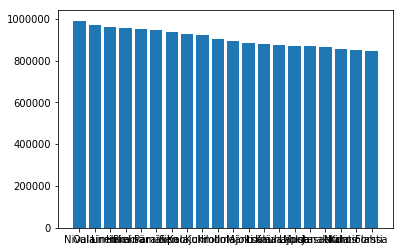

In [16]:
plt.bar(plotdat['kunta'], plotdat['maksetut_etuudet_euroa'])

## Datastore-api

Jos et tarvitse koko aineistoa, voit suodattaa siitä osio SQL:llä käyttäen CKAN:n DataStore-rajapintaa.

Alla olevassa esimerkissä tehdään rajaus `kunta`-muuttujasta ja siis etsitään vaan kuntaa *Veteli* koskevat tiedot.

In [17]:
kunta = "Veteli"
taulu = resources[0]['id']
muuttuja = 'kunta'
urli = f'https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from "{taulu}" WHERE {muuttuja} LIKE \'{kunta}\''
urli_plain = f'https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from "{taulu}"'
#urli = "https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from \"%s\" WHERE %s LIKE '%s'" % (taulu, muuttuja, kunta)
#urli_plain = "https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from \"%s\"" % (taulu)
response = urlopen(urli_plain)
da = json.loads(response.read())
dataa = json_normalize(da['result']['records'])
#dataa
print(dataa.head())

                                          _full_text  _id  aika aikajakso  \
0  '2007':4 '210':6 '2360':8 '495806':7 '5':1 '98...    1  2007     vuosi   
1  '143525':7 '2007':4 '3500':8 '41':6 '61':9 '9'...    2  2007     vuosi   
2  '10':1 '2007':4 '240':6 '2553':8 '612924':7 '8...    3  2007     vuosi   
3  '119':6 '16':1 '2007':4 '2514':8 '299271':7 '8...    4  2007     vuosi   
4  '12':9 '175090':7 '18':1 '2007':4 '3367':8 '52...    5  2007     vuosi   

       etuus euroa_per_saaja      kunta kuntanumero maksetut_etuudet_euroa  \
0  Kuntoutus         2360,98   Alajärvi           5                 495806   
1  Kuntoutus         3500,61  Alavieska           9                 143525   
2  Kuntoutus         2553,85     Alavus          10                 612924   
3  Kuntoutus         2514,88   Asikkala          16                 299271   
4  Kuntoutus         3367,12     Askola          18                 175090   

  saajat  
0    210  
1     41  
2    240  
3    119  
4     52  
